In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
import hvplot.pandas
import warnings
warnings.filterwarnings("ignore")




In [57]:
cryto = 'BTC'
currency= 'USD'

start = dt.datetime(2019,1,1) 
end= dt.datetime(2021,1,1)

data= web.DataReader(f'{cryto}-{currency}', 'yahoo', start, end)
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-29,27370.720703,25987.298828,27081.810547,27362.437500,45265946774,27362.437500
2020-12-30,28937.740234,27360.089844,27360.089844,28840.953125,51287442704,28840.953125
2020-12-31,29244.876953,28201.992188,28841.574219,29001.720703,46754964848,29001.720703
2021-01-01,29600.626953,28803.585938,28994.009766,29374.152344,40730301359,29374.152344
2021-01-02,33155.117188,29091.181641,29376.455078,32127.267578,67865420765,32127.267578


In [58]:
#filter the date index and close column
btc_df = data.loc[:,['Close']]

#generate returns from close prices
btc_df['Actual Returns'] = btc_df['Close'].pct_change()

btc_df = btc_df.dropna()

display(btc_df.head())
display(btc_df.tail())

,Close,Actual Returns
Date,,
2019-01-02,3943.409424,0.025989
2019-01-03,3836.741211,-0.027050
2019-01-04,3857.717529,0.005467
2019-01-05,3845.194580,-0.003246
2019-01-06,4076.632568,0.060189


,Close,Actual Returns
Date,,
2020-12-29,27362.437500,0.010250
2020-12-30,28840.953125,0.054034
2020-12-31,29001.720703,0.005574
2021-01-01,29374.152344,0.012842
2021-01-02,32127.267578,0.093726


# Generate trading with short and long window SMA values

In [59]:
#set short and long window value
short_window = 4
long_window = 100

In [60]:
# generate using short and long window value
btc_df['SMA_Fast'] = btc_df['Close'].rolling(window=short_window).mean()
btc_df['SMA_Slow'] = btc_df['Close'].rolling(window=long_window).mean()
btc_df = btc_df.dropna()

#review the df
display(btc_df.head())
display(btc_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2019-04-11,5064.487793,-0.048842,5220.942261,3932.092756
2019-04-12,5089.539062,0.004946,5170.884277,3943.554053
2019-04-13,5096.586426,0.001385,5143.791260,3956.152505
2019-04-14,5167.722168,0.013958,5104.583862,3969.252551
2019-04-15,5067.108398,-0.019470,5105.239014,3981.471689


,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2020-12-29,27362.437500,0.010250,26789.144531,15980.680898
2020-12-30,28840.953125,0.054034,27390.123535,16164.467832
2020-12-31,29001.720703,0.005574,28072.479980,16349.100439
2021-01-01,29374.152344,0.012842,28644.815918,16540.380098
2021-01-02,32127.267578,0.093726,29836.023438,16754.052109


In [61]:
# Create a Signal column to the original data
btc_df['Signal'] = 0.0

# when Actual Returns are greater than or equal to 0, signal to buy stock long
btc_df.loc[(btc_df['Actual Returns'] >=0), 'Signal'] = 1

# when Actual Returns are less than 0, signal to sell stock short
btc_df.loc[(btc_df['Actual Returns'] < 0), 'Signal'] = -1

#review
display(btc_df.head())
display(btc_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2019-04-11,5064.487793,-0.048842,5220.942261,3932.092756,-1.0
2019-04-12,5089.539062,0.004946,5170.884277,3943.554053,1.0
2019-04-13,5096.586426,0.001385,5143.791260,3956.152505,1.0
2019-04-14,5167.722168,0.013958,5104.583862,3969.252551,1.0
2019-04-15,5067.108398,-0.019470,5105.239014,3981.471689,-1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2020-12-29,27362.437500,0.010250,26789.144531,15980.680898,1.0
2020-12-30,28840.953125,0.054034,27390.123535,16164.467832,1.0
2020-12-31,29001.720703,0.005574,28072.479980,16349.100439,1.0
2021-01-01,29374.152344,0.012842,28644.815918,16540.380098,1.0
2021-01-02,32127.267578,0.093726,29836.023438,16754.052109,1.0


In [62]:
btc_df['Signal'].value_counts()

 1.0    341
-1.0    292
Name: Signal, dtype: int64

In [63]:
# calculate strategy returns and add to btc_df 
btc_df['Strategy Returns'] = btc_df['Actual Returns'] * btc_df['Signal'].shift()

btc_df = btc_df.dropna()

#review
display(btc_df.head())
display(btc_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2019-04-12,5089.539062,0.004946,5170.884277,3943.554053,1.0,-0.004946
2019-04-13,5096.586426,0.001385,5143.791260,3956.152505,1.0,0.001385
2019-04-14,5167.722168,0.013958,5104.583862,3969.252551,1.0,0.013958
2019-04-15,5067.108398,-0.019470,5105.239014,3981.471689,-1.0,-0.019470
2019-04-16,5235.559570,0.033244,5141.744141,3993.060959,1.0,-0.033244


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2020-12-29,27362.437500,0.010250,26789.144531,15980.680898,1.0,0.010250
2020-12-30,28840.953125,0.054034,27390.123535,16164.467832,1.0,0.054034
2020-12-31,29001.720703,0.005574,28072.479980,16349.100439,1.0,0.005574
2021-01-01,29374.152344,0.012842,28644.815918,16540.380098,1.0,0.012842
2021-01-02,32127.267578,0.093726,29836.023438,16754.052109,1.0,0.093726


<AxesSubplot:title={'center':'Bitcoin Strategy Returns'}, xlabel='Date'>

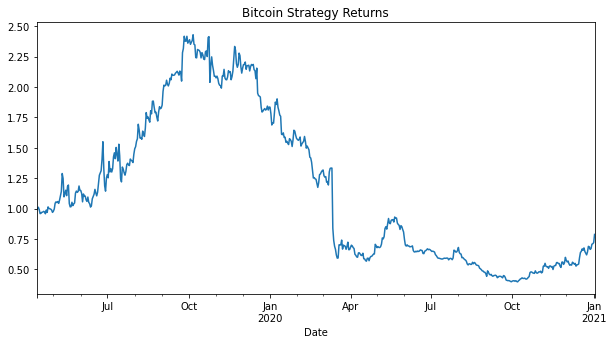

In [64]:
#plot btc strategy returns 
(1 + btc_df['Strategy Returns']).cumprod().plot(title='Bitcoin Strategy Returns',figsize=(10,5))

# Split data into training and testing

In [65]:
#Create a copy of sma fast and slow columns to dataframe X
X = btc_df[['SMA_Fast','SMA_Slow']].shift().dropna()
X.head()

,SMA_Fast,SMA_Slow
Date,,
2019-04-13,5170.884277,3943.554053
2019-04-14,5143.791260,3956.152505
2019-04-15,5104.583862,3969.252551
2019-04-16,5105.239014,3981.471689
2019-04-17,5141.744141,3993.060959


In [66]:
# create the target selecting Signal column
y= btc_df['Signal']

y.value_counts()


 1.0    341
-1.0    291
Name: Signal, dtype: int64

In [67]:
#select training start period
training_start = X.index.min()

print(training_start)

2019-04-13 00:00:00


In [82]:
# select the ending period 
training_end = X.index.min() + DateOffset(months=10)

print(training_end)

2020-02-13 00:00:00


In [83]:
# generate X train and y train df
X_train = X.loc[training_start:training_end]
y_train = y.loc[training_start:training_end]

display(X_train.head())
display(y_train.head())

,SMA_Fast,SMA_Slow
Date,,
2019-04-13,5170.884277,3943.554053
2019-04-14,5143.791260,3956.152505
2019-04-15,5104.583862,3969.252551
2019-04-16,5105.239014,3981.471689
2019-04-17,5141.744141,3993.060959


Date
2019-04-13    1.0
2019-04-14    1.0
2019-04-15   -1.0
2019-04-16    1.0
2019-04-17    1.0
Name: Signal, dtype: float64

In [84]:
# generate the X test and y test df
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

display(X_test.head())
display(y_test.head())

,SMA_Fast,SMA_Slow
Date,,
2020-02-14,10151.320557,8174.406138
2020-02-15,10265.196777,8183.918501
2020-02-16,10185.493896,8190.137134
2020-02-17,10087.588623,8201.432661
2020-02-18,9956.529297,8210.198267


Date
2020-02-14    1.0
2020-02-15   -1.0
2020-02-16    1.0
2020-02-17   -1.0
2020-02-18    1.0
Name: Signal, dtype: float64

In [85]:
#Scale the feature dataframes
#Create a standard scaler instance
btc_standard_scaler = StandardScaler()

#Apply the scaler model to fit X train data
X_scaler = btc_standard_scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Fit the training data and make predictions based on testing data

In [72]:
# from SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

svm_model = svm_model.fit(X_train_scaled,y_train)
svm_predict = svm_model.predict(X_test_scaled)

svm_predict[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Review classifcation report with the model prediction.

In [73]:
#use svm testing report to evaluate model
svm_testing_report = classification_report(y_test,svm_predict)

print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.39      0.32      0.35       141
         1.0       0.54      0.61      0.57       183

    accuracy                           0.48       324
   macro avg       0.46      0.47      0.46       324
weighted avg       0.47      0.48      0.48       324



# Create a prediction DataFrame that contain for Predicted values for Actual and Strategy Returns

In [74]:
# Create a new empty predcition DF
prediction_df = pd.DataFrame(index=X_test.index)

#Add the SVM model prediction to the DataFrame
prediction_df['Predicted'] = svm_predict
#Add the actual returns to the dataframe
prediction_df['Actual Returns'] = btc_df['Actual Returns']
#Add the strategy returns to the DataFrame
prediction_df['Strategy Returns'] = (
    prediction_df['Actual Returns'] * prediction_df['Predicted']
)

#review
display(prediction_df.head())
display(prediction_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2020-02-14,1.0,0.009569,0.009569
2020-02-15,1.0,-0.040990,-0.040990
2020-02-16,1.0,0.004551,0.004551
2020-02-17,1.0,-0.024590,-0.024590
2020-02-18,1.0,0.046630,0.046630


,Predicted,Actual Returns,Strategy Returns
Date,,,
2020-12-29,1.0,0.010250,0.010250
2020-12-30,1.0,0.054034,0.054034
2020-12-31,1.0,0.005574,0.005574
2021-01-01,1.0,0.012842,0.012842
2021-01-02,1.0,0.093726,0.093726


<AxesSubplot:title={'center':'SVM Strategy vs Actual BTC Prediction'}, xlabel='Date'>

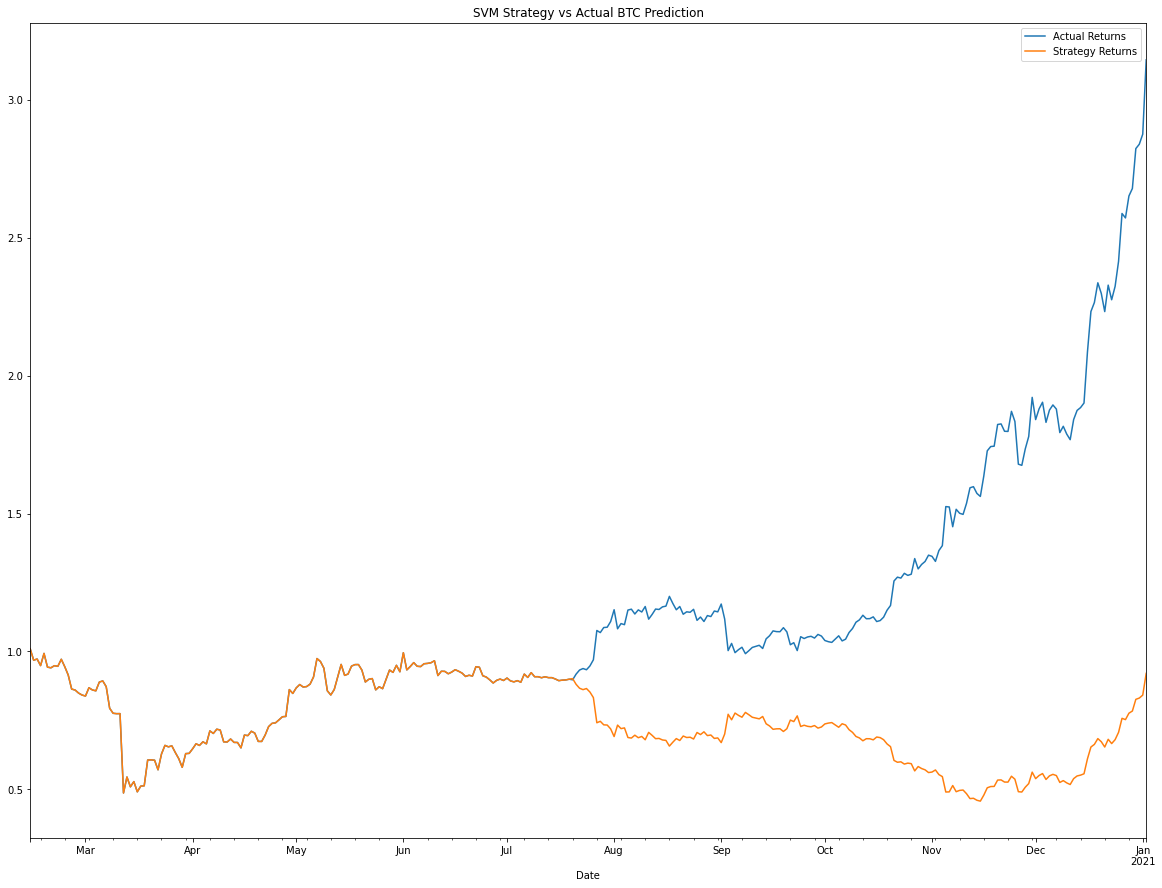

In [87]:
#Plot actual return vs strategy

(1 + prediction_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot(title='SVM Strategy vs Actual BTC Prediction', figsize=(20,15))

these are the imported libraries:

from sklearn.metrics import classification_report
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
import hvplot.pandas


